In [1]:
import scipy
import io
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from monai.networks.nets import unet
from torch.utils.data import DataLoader, Dataset, random_split
import csv
import pandas as pd

import numpy as np
import SimpleITK as sitk
import torchio as tio
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")
from multiprocessing import Manager
import configparser

from typing import Optional

import warnings
warnings.filterwarnings('ignore')

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/spack/apps/linux-centos7-x86_64/gcc-8.3.0/python-3.9.2-uvcroioc4witkp6qf7mbebof5ix4wlb6/lib/python3.9/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:569: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  (np.object, string),
/spack/apps/linux-centos7-x86_64/gcc-8.3.0/python-3.9.2-uvcroioc4witkp6qf7mbebof5ix4wlb6/lib/python3.9/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:569: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  (np.object, string),


In [2]:
config = {
    'batch_size': 5,
    'imgDimResize': (208, 248, 208),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '2D',
    'unisotropic_sampling': True, 
    'perc_low': 1, 
    'perc_high': 99, 
}

In [3]:
def Train(csv,cfg,preload=True):
    subjects = []
    for _, sub in csv.iterrows():
        subject_dict = {
            'vol' : tio.ScalarImage(sub.img_path, reader=sitk_reader), 
            'age' : sub.age,
            'sex' : sub.sex,
            'Dataset' : sub.Dataset,
            'ID' : sub.ID,
            'path' : sub.img_path
        }

        subject = tio.Subject(subject_dict)
        subjects.append(subject)
    
    if preload: 
        manager = Manager()
        cache = DatasetCache(manager)
        ds = tio.SubjectsDataset(subjects, transform = get_transform(cfg))
        ds = preload_wrapper(ds, cache, augment = get_augment(cfg))
    else: 
        ds = tio.SubjectsDataset(subjects, transform = tio.Compose([get_transform(cfg),get_augment(cfg)]))
        
    if cfg.get('spatialDims') == '2D':
        slice_ind = cfg.get('startslice',None) 
        seq_slices = cfg.get('sequentialslices',None) 
        ds = vol2slice(ds,cfg,slice=slice_ind,seq_slices=seq_slices)
    return ds

def sitk_reader(path):
                
    image_nii = sitk.ReadImage(str(path), sitk.sitkFloat32)
    vol = sitk.GetArrayFromImage(image_nii).transpose(2,1,0)
    return vol, None


def get_transform(cfg): # only transforms that are applied once before preloading
        
    if cfg.get('unisotropic_sampling',True):
        preprocess = tio.Compose([
        tio.Resize(cfg.get('imageDimResize',(208, 248, 208))),
        tio.CropOrPad(cfg.get('imageDimPad',(208, 256, 208)),padding_mode=0),
        tio.RescaleIntensity((0, 1),percentiles=(cfg.get('perc_low',1),cfg.get('perc_high',99))),
        ])

    else: 
        preprocess = tio.Compose([
                tio.RescaleIntensity((0, 1),percentiles=(cfg.get('perc_low',1),cfg.get('perc_high',99))),
                tio.Resample(cfg.get('rescaleFactor',3.0),image_interpolation='bspline',exclude=exclude_from_resampling),#,exclude=['vol_orig','mask_orig','seg_orig']), # we do not want to resize *_orig volumes
            ])


    return preprocess

class DatasetCache(object):
    def __init__(self, manager, use_cache=True):
        self.use_cache = use_cache
        self.manager = manager
        self._dict = manager.dict()

    def is_cached(self, key):
        if not self.use_cache:
            return False
        return str(key) in self._dict

    def reset(self):
        self._dict.clear()

    def get(self, key):
        if not self.use_cache:
            raise AttributeError('Data caching is disabled and get funciton is unavailable! Check your config.')
        return self._dict[str(key)]

    def cache(self, key, subject):
        # only store if full data in memory is enabled
        if not self.use_cache:
            return
        # only store if not already cached
        if str(key) in self._dict:
            return
        self._dict[str(key)] = (subject)

class preload_wrapper(Dataset):
    def __init__(self,ds,cache,augment=None):
            self.cache = cache
            self.ds = ds
            self.augment = augment
    def reset_memory(self):
        self.cache.reset()
    def __len__(self):
            return len(self.ds)
            
    def __getitem__(self, index):
        if self.cache.is_cached(index) :
            subject = self.cache.get(index)
        else:
            subject = self.ds.__getitem__(index)
            self.cache.cache(index, subject)
        if self.augment:
            subject = self.augment(subject)
        return subject
    
class vol2slice(Dataset):
    def __init__(self,ds,cfg,onlyBrain=False,slice=None,seq_slices=None):
            self.ds = ds
            self.onlyBrain = onlyBrain
            self.slice = slice
            self.seq_slices = seq_slices
            self.counter = 0 
            self.ind = None
            self.cfg = cfg

    def __len__(self):
            return len(self.ds)
            
    def __getitem__(self, index):
        subject = self.ds.__getitem__(index)
        
        #Commenting the next few lines to introduce a simple masking operation
#         if self.onlyBrain:
#             start_ind = None
#             for i in range(subject['vol'].data.shape[-1]):
#                 if subject['mask'].data[0,:,:,i].any() and start_ind is None: # only do this once
#                     start_ind = i 
#                 if not subject['mask'].data[0,:,:,i].any() and start_ind is not None: # only do this when start_ind is set
#                     stop_ind = i 
#             low = start_ind
#             high = stop_ind
#         else: 
#             low = 0
#             high = subject['vol'].data.shape[-1]
#         if self.slice is not None:
#             self.ind = self.slice
#             if self.seq_slices is not None:
#                 low = self.ind
#                 high = self.ind + self.seq_slices
#                 self.ind = torch.randint(low,high,size=[1])
#         else:
#             if self.cfg.get('unique_slice',False): # if all slices in one batch need to be at the same location
#                 if self.counter % self.cfg.batch_size == 0 or self.ind is None: # only change the index when changing to new batch
#                     self.ind = torch.randint(low,high,size=[1])
#                 self.counter = self.counter +1
#             else: 
#                 self.ind = torch.randint(low,high,size=[1])

#         subject['ind'] = self.ind

#         subject['vol'].data = subject['vol'].data[...,self.ind]
#         subject['mask'].data = subject['mask'].data[...,self.ind]


        subject['vol'].data = subject['vol'].data.permute(0,3, 2, 1)
    
        #msk_normal = ~np.all(subject['vol'].data.numpy()[0] == 0,axis=(1,2)) # Remove empty planes (Replacing this line of code to include slices that have significant prain volume in them (more than 15% of the image is brain))
        
        msk_normal = (np.count_nonzero(subject['vol'].data.numpy()[0],axis=(1,2))/(subject['vol'].data.numpy()[0].shape[1]*subject['vol'].data.numpy()[0].shape[2]))>=0.15
        
        choices = np.arange(len(msk_normal))[msk_normal]
        
        sample_idx = np.array(random.choices(choices,k = 1))
        
        subject['vol'].data = subject['vol'].data[0:2, sample_idx, ...]

        return subject

def get_augment(cfg): # augmentations that may change every epoch
    augmentations = []

    # individual augmentations
    augment = tio.Compose(augmentations)
    return augment

In [4]:
data_train = Train(pd.read_csv('/scratch1/zamzam/train.csv', converters={'img_path': pd.eval}), config)
train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=1)

data_val = Train(pd.read_csv('/scratch1/zamzam/val.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=1)

data_test = Train(pd.read_csv('/scratch1/zamzam/test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=1)

In [5]:
s = next(iter(train_loader))

In [6]:
print(s.keys())
print(s['age'])
print(s['Dataset'])
print(s['sex'])

dict_keys(['vol', 'age', 'sex', 'Dataset', 'ID', 'path'])
tensor([31.0000, 28.2500, 31.0000, 26.0000, 82.5000], dtype=torch.float64)
['HCP', 'CAMCAN', 'HCP', 'HCP', 'CAMCAN']
['M', 'M', 'F', 'M', 'M']


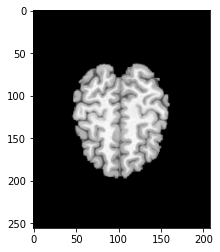

In [7]:
image_array = s['vol']['data'][0][0].squeeze().cpu().numpy()
plt.imshow(image_array, cmap='gray');